In [1]:
import pandas as pd
import tensorflow as tf
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from tensorflow.python.keras.preprocessing.text import Tokenizer 
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, CuDNNLSTM, Dropout
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import EarlyStopping
from attention import AttentionLayer
from itertools import chain
import sys
from beam_search import beam_search

In [2]:

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [2]:
df = pd.read_csv('arts_and_sports.csv')

In [3]:
df.shape #Before cleaning

(3148, 5)

In [4]:
#Data cleaning
df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(axis=0,inplace=True)

In [5]:
df.shape #After cleaning

(3113, 5)

In [6]:
#data preprocessing
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [7]:
#All credits to preprocessing stage goes to https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "html.parser").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in df['text']:
    cleaned_text.append(text_cleaner(t))

In [8]:
def headline_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString


cleaned_headline = []
for t in df['title']:
    cleaned_headline.append(headline_cleaner(t))

In [9]:
df['cleaned text'] = cleaned_text
df['cleaned headline'] = cleaned_headline
df['cleaned headline'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)
df['cleaned headline'] = df['cleaned headline'].apply(lambda x : '_START_ '+ x + ' _END_')

In [10]:
df.head()

,link,title,date,author,text,cleaned text,cleaned headline
0,https://www.nytimes.com/2018/12/05/books/the-w...,The Way We Read \n,2018-12-05\n,Erica Ackerberg\n,Donald and Patricia Oresman's New York City ho...,donald patricia oresman new york city home des...,_START_ the way we read _END_
1,https://www.nytimes.com/2018/12/07/books/revie...,Colm Toibin on the Fathers of Geniuses \n,2018-12-07\n,Gregory Cowles\n,"MAD, BAD, DANGEROUS TO KNOW The Fathers of Wil...",mad bad dangerous know fathers wilde yeats joy...,_START_ colm toibin on the fathers of geniuses...
2,https://www.nytimes.com/2018/12/21/world/afric...,"Guitarist Has Brain Surgery, and Strums All th...",2018-12-21\n,Kimon de Greef\n,CAPE TOWN - A musician from South Africa had a...,cape town musician south africa tumor brain do...,_START_ guitarist has brain surgery and strums...
3,https://www.nytimes.com/2019/01/17/movies/film...,4 Film Series to Catch in N.Y.C. This Weekend \n,2019-01-17\n,Ben Kenigsberg\n,Our guide to film series and special screening...,guide film series special screenings happening...,_START_ film series to catch in this weekend ...
4,https://www.nytimes.com/2018/12/03/arts/music/...,"Review: Exploring Langston Hughes in Song, Loc...",2018-12-03\n,Zachary Woolfe\n,"On the morning of July 16, 1964, James Powell,...",morning july james powell year old black stude...,_START_ review exploring langston hughes in so...


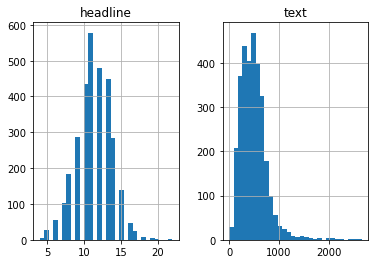

In [11]:
#data analysis
#compute text length
text_word_counts = []
headline_word_counts = []
for i in df['cleaned text']:
    text_word_counts.append(len(i.split()))
    
for i in df['cleaned headline']:
    headline_word_counts.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_counts, 'headline':headline_word_counts})
length_df.hist(bins = 30)
plt.show()

In [12]:
max_headline_length = 22
max_text_length = 1500  #a majority of texts are below 1500 with several outliers, so we set max text length to 1500


In [13]:
x_train, x_test, y_train, y_test = train_test_split(list(df['cleaned text']), list(df['cleaned headline']), random_state = 0, shuffle = True)

In [14]:
#text tokenization. Credits go to https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))


x_train =  x_tokenizer.texts_to_sequences(x_train) 
x_test = x_tokenizer.texts_to_sequences(x_test)


x_train = pad_sequences(x_train,  maxlen=max_text_length, padding='post') 
x_test = pad_sequences(x_test, maxlen=max_text_length, padding='post')

x_voc_size = len(x_tokenizer.word_index) +1


In [15]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_train =  y_tokenizer.texts_to_sequences(y_train) 
y_test =  y_tokenizer.texts_to_sequences(y_test) 

y_train =  pad_sequences(y_train, maxlen=max_headline_length, padding='post')
y_test =  pad_sequences(y_test, maxlen=max_headline_length, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

In [27]:
from tensorflow.python.keras import backend as K 
K.clear_session() 
latent_dim = 300 

# Encoder 
encoder_inputs = Input(shape=(max_text_length,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 
dropout = Dropout(0.2)
enc_emb = dropout(enc_emb)


encoder_lstm1 = CuDNNLSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)


encoder_output1 = dropout(encoder_output1)


encoder_lstm2 = CuDNNLSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 
dec_emb = dropout(dec_emb)

#LSTM 
decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

model.summary()

encoder outputs shape:  (?, 1500, 300)
decoder outputs shape:  (?, ?, 300)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    1758900     input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    17101800    input_1[0][0]                    
___________________

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [30]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=20,batch_size=128, validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))


Train on 2334 samples, validate on 779 samples
Epoch 1/20
2334/2334 [==============================] - 26s 11ms/sample - loss: 5.3727 - acc: 0.4825 - val_loss: 2.9491 - val_acc: 0.5733
Epoch 2/20
2334/2334 [==============================] - 23s 10ms/sample - loss: 3.6047 - acc: 0.5167 - val_loss: 2.8397 - val_acc: 0.6008
Epoch 3/20
2334/2334 [==============================] - 23s 10ms/sample - loss: 3.4650 - acc: 0.5337 - val_loss: 2.7432 - val_acc: 0.6242
Epoch 4/20
2334/2334 [==============================] - 23s 10ms/sample - loss: 3.3597 - acc: 0.5621 - val_loss: 2.6937 - val_acc: 0.6330
Epoch 5/20
2334/2334 [==============================] - 23s 10ms/sample - loss: 3.3072 - acc: 0.5697 - val_loss: 2.6798 - val_acc: 0.6349
Epoch 6/20
2334/2334 [==============================] - 23s 10ms/sample - loss: 3.2698 - acc: 0.5717 - val_loss: 2.6860 - val_acc: 0.6321
Epoch 7/20
2334/2334 [==============================] - 23s 10ms/sample - loss: 3.2375 - acc: 0.5728 - val_loss: 2.6910 - val

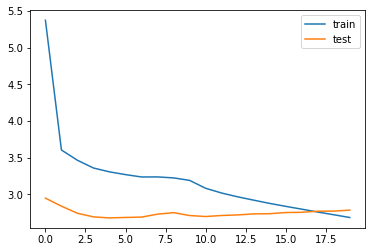

In [33]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

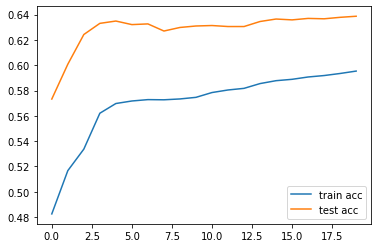

In [35]:
pyplot.plot(history.history['acc'], label='train acc') 
pyplot.plot(history.history['val_acc'], label='test acc') 
pyplot.legend() 
pyplot.show()

In [36]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [38]:
#Credits for the inference model goes to https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_length,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [39]:
np.set_printoptions(threshold=sys.maxsize)

In [40]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        #output tokens should be fine
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        sampled_token = reverse_target_word_index[sampled_token_index]
        #print(sampled_token_index)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
            

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_headline_length-1)):      
            stop_condition = True
            #print (output_tokens)
            
            
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [41]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [42]:
for i in range(30):
  #print("News:",seq2text(x_test[i]))
  print("Original headline:",seq2summary(y_test[i]))
  print("Predicted headline:",decode_sequence(x_test[i].reshape(1,max_text_length)))
  print("\n")

Original headline: what on tv friday fyre and grace and frankie 
Predicted headline:  the best best the the the open


Original headline: renaissance style experts in on of centuries past 
Predicted headline:  the best best the the the open


Original headline: paxton and davis once are suddenly 
Predicted headline:  the best best weekend


Original headline: of our best weekend reads 
Predicted headline:  the best best weekend


Original headline: review an look at an 
Predicted headline:  the the the the the the the the the the the the the the the the the the the the the


Original headline: she left tennis in now patty is back at the open 
Predicted headline:  the the the the the the the the the the the the the the the the the the the the the


Original headline: brewers and dodgers claim division titles in game no 
Predicted headline:  the the the the the the the the the the the the the the the the the the the the the


Original headline: playing golf tiger woods feels different no